# 4: Calculating and Analyzing Customer Lifetime Value

In this Jupyter notebook, we will delve into the process of calculating and analyzing the Customer Lifetime Value (CLV). Customer lifetime value is a crucial metric that helps organizations understand the long-term value of their customer relationships and make strategic decisions accordingly. By analyzing CLV, businesses can identify their most valuable customers, optimize marketing efforts, and improve customer retention strategies.

## Key Takeaways

The analysis provided in this notebook can help the business:

- Identify their most valuable customers and focus marketing efforts on retaining and expanding these relationships.
- Understand the transition patterns of customers between different segments, enabling the development of targeted retention strategies.
- Forecast the future composition of the customer base, allowing the business to plan resources and investments accordingly.
- Continuously monitor and optimize the customer lifetime value of their customer base, driving long-term profitability and growth.

## Conclusion

This notebook offers a comprehensive approach to calculating and analyzing customer lifetime value, providing valuable insights to help the business make data-driven decisions and enhance its customer-centric strategies.


In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define Helper Functions

In [34]:
"""
    Loads sales data from text file
"""
def load_sales_data():
    df = pd.read_csv(
    'raw_orders.txt',
    header=None,sep='\t',
    parse_dates=[2],
    names=['customer_id','purchase_amount','date_of_purchase'])
    df['year_of_purchase'] = df.date_of_purchase.dt.year
    return df

"""
    Creates a retrospective snapshot of the sales data as of a given date in the past
"""
def retro(sales_data,retrospective_date):
    retro_date = pd.to_datetime(retrospective_date)
    retro_sales_data = sales_data[sales_data.date_of_purchase < retro_date].copy()
    retro_sales_data['days_since'] = (retro_date - retro_sales_data.date_of_purchase).dt.days
    return retro_sales_data

"""
    Calculate per customer RFM (recency, frequency, money) statistics
"""
def rfm(sales_df,year=None):
    g = sales_df.groupby(by='customer_id')
    df = pd.DataFrame({
        'recency' : g.days_since.min(), 
        'first_purchase' : g.days_since.max(),
        'frequency' : g.days_since.count(), 
        'avg_amount' : g.purchase_amount.mean(),
        'max_amount' : g.purchase_amount.max()}, 
        columns= ['recency','first_purchase','frequency','avg_amount','max_amount'])
    if year:
        df['year'] = year
    return df

"""
    Create a panel of of per customer RFM (recency, frequency, money) statistic per year
"""
def rfm_panel(sales_df):
    retrospective_dates = pd.to_datetime(np.sort(sales_df.date_of_purchase.dt.year.unique()) + 1,format='%Y')
    customers = pd.concat([rfm(retro(sales_df,date),date.year -1) for date in retrospective_dates])
    customers.set_index('year',append=True,inplace=True)
    customers.sort_index(inplace=True)
    return customers

"""
    Segment customers based upon RFM statistics
"""
def segment(customers):
    customers['segment'] = 'NA'
    # segment by recency
    customers.loc[customers.recency > 365*3,'segment'] = 'inactive'
    customers.loc[(customers.recency <= 365*3) & (customers.recency > 365*2),'segment'] = 'cold'
    customers.loc[(customers.recency <= 365*2) & (customers.recency > 365*1),'segment'] = 'warm'
    customers.loc[customers.recency <= 365*1,'segment'] = 'active'
    # segment warm into (new, low value, high value)
    customers.loc[(customers.segment == 'warm') & (customers.first_purchase <= 365*2),'segment'] = 'new warm'
    customers.loc[(customers.segment == 'warm') & (customers.avg_amount < 100),'segment'] = 'warm low value'
    customers.loc[(customers.segment == 'warm') & (customers.avg_amount >= 100),'segment'] = 'warm high value'
    # segment active into (new, low value, high value)
    customers.loc[(customers.segment == 'active') & (customers.first_purchase <= 365),'segment'] = 'new active'
    customers.loc[(customers.segment == 'active') & (customers.avg_amount < 100),'segment'] = 'active low value'
    customers.loc[(customers.segment == 'active') & (customers.avg_amount >= 100),'segment'] = 'active high value'
    customers.segment = order_segments(customers.segment)
    customers.segment.fillna(np.NAN)
    return customers

def order_segments(s):
    return s.astype("category", categories=[
        "inactive",
        "cold",
        "warm high value", "warm low value","new warm",
        "active high value", "active low value", "new active"
        ],ordered=True)


# Load and Prepare RFM Panel

In [3]:
sales_df = load_sales_data()
customers = segment(rfm_panel(sales_df))
customers.head(22)

recency  first_purchase  frequency  avg_amount  max_amount  \
customer_id year                                                               
10          2005      177             177          1   30.000000        30.0   
            2006      542             542          1   30.000000        30.0   
            2007      907             907          1   30.000000        30.0   
            2008     1273            1273          1   30.000000        30.0   
            2009     1638            1638          1   30.000000        30.0   
            2010     2003            2003          1   30.000000        30.0   
            2011     2368            2368          1   30.000000        30.0   
            2012     2734            2734          1   30.000000        30.0   
            2013     3099            3099          1   30.000000        30.0   
            2014     3464            3464          1   30.000000        30.0   
            2015     3829            3829          1   30.000000        30.0   
80          2005       99              99          1   50.000000        50.0   
            2006      464             464          1   50.000000        50.0   
            2007      258             829          2   55.000000        60.0   
            2008      624            1195          2   55.000000        60.0   
            2009      266            1560          3   60.000000        70.0   
            2010      631            1925          3   60.000000        70.0   
            2011      149            2290          4   65.000000        80.0   
            2012      515            2656          4   65.000000        80.0   
            2013      147            3021          5   68.000000        80.0   
            2014      302            3386          6   70.000000        80.0   
            2015      343            3751          7   71.428571        80.0   

                           segment  
customer_id year                    
10          2005        new active  
            2006          new warm  
            2007              cold  
            2008          inactive  
            2009          inactive  
            2010          inactive  
            2011          inactive  
            2012          inactive  
            2013          inactive  
            2014          inactive  
            2015          inactive  
80          2005        new active  
            2006          new warm  
            2007  active low value  
            2008    warm low value  
            2009  active low value  
            2010    warm low value  
            2011  active low value  
            2012    warm low value  
            2013  active low value  
            2014  active low value  
            2015  active low value

# Compute Transition Matrix

In [26]:
segmentation_by_year = customers.segment.unstack('year')
cust_segs_2014 = segmentation_by_year[2014]
cust_segs_2015 = segmentation_by_year[2015]
pd.crosstab(index=cust_segs_2015,columns=cust_segs_2014,margins=False)

2014,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active
2015,,,,,,,,
inactive,7227,1931,0,0,0,0,0,0
cold,0,0,75,689,1139,0,0,0
warm high value,0,0,0,0,0,119,0,0
warm low value,0,0,0,0,0,0,901,0
new warm,0,0,0,0,0,0,0,938
active high value,35,22,35,1,15,354,22,89
active low value,250,200,1,266,96,2,2088,410
new active,0,0,0,0,0,0,0,0


In [30]:
transition = pd.crosstab(index=cust_segs_2015,columns=cust_segs_2014,normalize='columns',margins=False)
transition

2014,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active
2015,,,,,,,,
inactive,0.962061,0.896888,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
cold,0.000000,0.000000,0.675676,0.720711,0.9112,0.000000,0.000000,0.000000
warm high value,0.000000,0.000000,0.000000,0.000000,0.0000,0.250526,0.000000,0.000000
warm low value,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.299236,0.000000
new warm,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.652749
active high value,0.004659,0.010218,0.315315,0.001046,0.0120,0.745263,0.007307,0.061935
active low value,0.033280,0.092894,0.009009,0.278243,0.0768,0.004211,0.693457,0.285317
new active,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000


# Use Transition Matrix to Compute Customer Evolution

In [32]:
A = transition.as_matrix()
years = np.arange(2015,2026)
segments_year_0 = customers.segment.xs(years[0],level='year').value_counts().sort_index()
segments = pd.DataFrame(index=segments_year_0.index,columns=years)
segments[years[0]] = segments_year_0
for year in years[1:]:
    segments[year] = A.dot(segments[year - 1])
segments = np.round(segments).astype(int)
segments

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158,10517,11539,12636,12940,13186,13386,13542,13664,13759,13834
cold,1903,1584,1711,874,821,782,740,709,684,665,650
warm high value,119,144,165,160,156,152,149,146,143,141,139
warm low value,901,991,1058,989,938,884,844,813,789,771,756
new warm,938,987,0,0,0,0,0,0,0,0,0
active high value,573,657,639,624,607,593,581,571,562,554,547
active low value,3313,3537,3305,3134,2954,2820,2717,2637,2575,2527,2490
new active,1512,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>


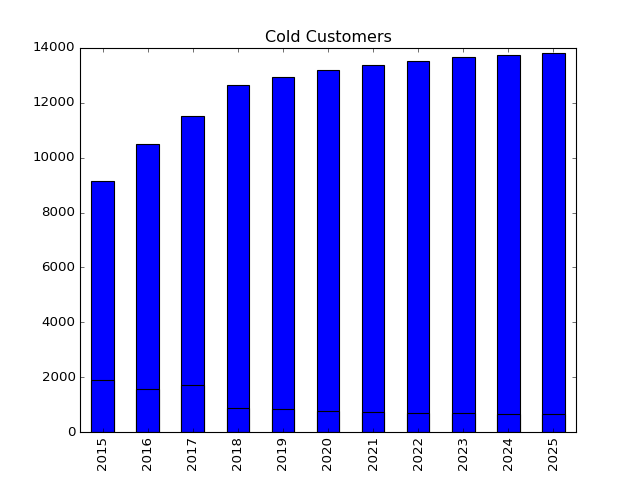

In [7]:
segments.loc['inactive',:].plot.bar(title="Inactive Customers")

<IPython.core.display.Javascript object>


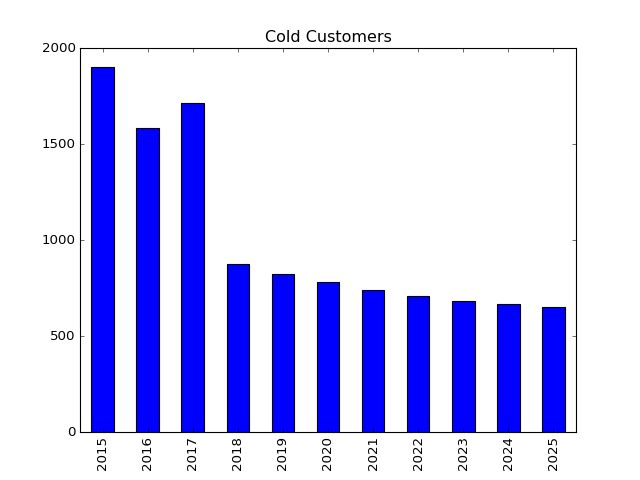

In [33]:
segments.loc['cold',:].plot.bar(title="Cold Customers")

<IPython.core.display.Javascript object>


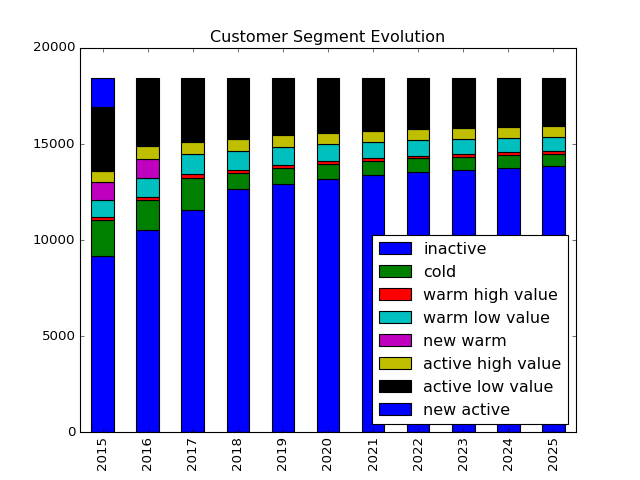

In [15]:
segments.T.plot.bar(stacked=True,title="Customer Segment Evolution")

## Estimate Dollars Value of Segments

In [10]:
g = sales_df.groupby(by=['customer_id','year_of_purchase'])
revenues = pd.DataFrame({
            'revenue' : g.purchase_amount.sum()
    })
revenues.index.rename(['customer_id','year'],inplace=True)
r = revenues.join(customers.segment,how='right')
r.revenue.fillna(0,inplace=True)
yearly_revenue = r.xs(2015,level='year').groupby('segment').mean().sort_index()
# yearly_revenue = pd.Series([0,0,0,0,0,323.57,52.30,79.17],index=yearly_revenue.index)
yearly_revenue

,revenue
segment,
inactive,0.000000
cold,0.000000
warm high value,0.000000
warm low value,0.000000
new warm,0.000000
active high value,323.568935
active low value,52.306043
new active,79.166144


In [17]:
revenue = yearly_revenue.values * segments
np.round(revenue)

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warm high value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warm low value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
new warm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
active high value,185405.0,212585.0,206761.0,201907.0,196406.0,191876.0,187994.0,184758.0,181846.0,179257.0,176992.0
active low value,173290.0,185006.0,172871.0,163927.0,154512.0,147503.0,142116.0,137931.0,134688.0,132177.0,130242.0
new active,119699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
np.round(revenue.sum())

2015    478394.0
2016    397591.0
2017    379632.0
2018    365834.0
2019    350918.0
2020    339379.0
2021    330109.0
2022    322689.0
2023    316534.0
2024    311435.0
2025    307234.0
dtype: float64

### Discount Revenue Stream

In [21]:
discount_rate = .10
discount = pd.Series([1.0/(1 + discount_rate)**(i-years[0]) for i in years],index=years)
discount

2015    1.000000
2016    0.909091
2017    0.826446
2018    0.751315
2019    0.683013
2020    0.620921
2021    0.564474
2022    0.513158
2023    0.466507
2024    0.424098
2025    0.385543
dtype: float64

<IPython.core.display.Javascript object>


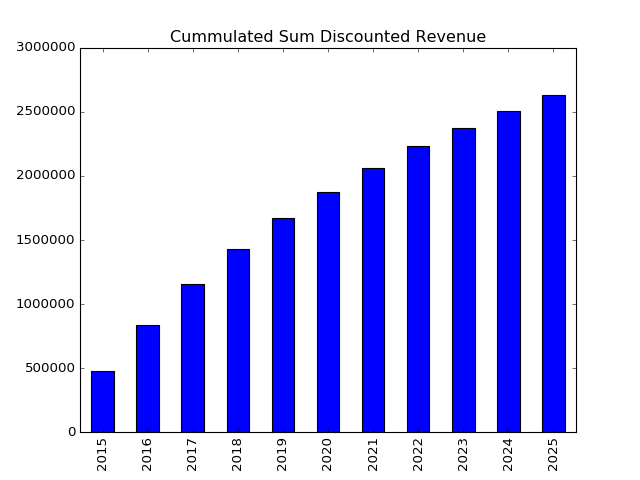

In [24]:
discounted_revenue = revenue * discount
discounted_revenue.sum().cumsum().plot.bar(title='Cummulated Sum Discounted Revenue')

In [25]:
np.round(discounted_revenue.sum())

2015    478394.0
2016    361447.0
2017    313745.0
2018    274857.0
2019    239682.0
2020    210728.0
2021    186338.0
2022    165590.0
2023    147665.0
2024    132079.0
2025    118452.0
dtype: float64